# Heterogenous Modelling
Using different kinds of distributions to model data, instead of only a single kind of distribution.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.append('../')
import utils as utl
import datasets as d
import models as m

tfd = tfp.distributions
tfm = tf.math

%load_ext autoreload
%autoreload 2

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sap98\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Get Toy Data

In [2]:
N = 10000
data = d.gen_checkerboard_d3split(batch_size=N)
batched = d.to_tf_dataset(data, batch_size=200)

In [3]:
# also get the three category splits
idx_1 = data[:, 2] == 0
idx_2 = data[:, 2] == 1
idx_3 = data[:, 2] == 2
points_1 = data[idx_1, 0:2]
points_2 = data[idx_2, 0:2]
points_3 = data[idx_3, 0:2]

## Define Model

In [40]:
# Number of components per distribution
K_TT = 10   # 5, 10
K_CP = 70   # 18, 70
K_TT_2D = 3
# Number of dimensions of the data (features)
M = data.shape[1]

In [41]:
# Define a distribution for each dimension of the data
dists = [
    tfd.Normal,     # dimension 1
    tfd.Normal,     # dimension 2
    tfd.Categorical # dimension 3
]
dists_GMM = [
    tfd.Normal,
    tfd.Normal,
    tfd.Normal
]
dists_GMM_2d = [
    tfd.Normal,
    tfd.Normal
]

In [42]:
# Define the parameters used by the models
params_TT = [
    [
        # distribution 1 (normal)
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        # distribution 2 (normal)
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        # distribution 3 (categorical)
        np.ones((K_TT, K_TT, 3))
    ]
]

params_CP = [
    [
        np.random.uniform(-4, 4, (K_CP, )),
        np.random.uniform(0, 4, (K_CP, ))
    ], [
        np.random.uniform(-4, 4, (K_CP, )),
        np.random.uniform(0, 4, (K_CP, ))
    ], [
        np.ones((K_CP, 3))
    ],
]

params_GMM = [
    [
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ], [
        np.random.uniform(-4, 4, (K_TT, K_TT)),
        np.random.uniform(0, 4, (K_TT, K_TT))
    ]
]

params_GMM_2d = [
    [
        np.random.uniform(-4, 4, (K_TT_2D, K_TT_2D)),
        np.random.uniform(0, 4, (K_TT_2D, K_TT_2D))
    ], [
        np.random.uniform(-4, 4, (K_TT_2D, K_TT_2D)),
        np.random.uniform(0, 4, (K_TT_2D, K_TT_2D))
    ]
]

In [43]:
# Define the modifyer used for each dimension
# set to None for categorical
modifiers = {
    0: {1: tfm.softplus},
    1: {1: tfm.softplus}
}
modifiers_GMM = {
    0: {1: tfm.softplus},
    1: {1: tfm.softplus},
    2: {1: tfm.softplus}
}

In [52]:
# Instantiate models
TT = m.TensorTrainGeneral(K_TT, dists, params_TT, modifiers)
CP = m.CPGeneral(K_CP, dists, params_CP, modifiers)
GMM = m.TensorTrainGeneral(K_TT, dists_GMM, params_GMM, modifiers_GMM)

GMM_1 = m.TensorTrainGeneral(K_TT_2D, dists_GMM_2d, params_GMM_2d, modifiers)
GMM_2 = m.TensorTrainGeneral(K_TT_2D, dists_GMM_2d, params_GMM_2d, modifiers)
GMM_3 = m.TensorTrainGeneral(K_TT_2D, dists_GMM_2d, params_GMM_2d, modifiers)

## Fit models to data

In [53]:
# Define number of epochs to train on
EPOCHS = 250

In [54]:
# Training optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [60]:
# train TT
losses_TT = TT.fit(batched, EPOCHS, optimizer, tolerance=0)

Training TT: 100%|██████████| 250/250 [00:58<00:00,  4.24it/s]Training time elapsed: 58 seconds
Final loss: 3.5702008056640624



In [63]:
# train CP
losses_CP = CP.fit(batched, EPOCHS, optimizer)

Training CPGeneral: 100%|██████████| 250/250 [00:32<00:00,  7.61it/s]Training time elapsed: 32 seconds
Final loss: 3.608013000488281



In [64]:
# train GMM
losses_GMM = GMM.fit(batched, EPOCHS, optimizer, tolerance=0)

losses_GMM_1 = GMM_1.fit(d.to_tf_dataset(points_1, batch_size=200), EPOCHS, optimizer, tolerance=0)
losses_GMM_2 = GMM_2.fit(d.to_tf_dataset(points_2, batch_size=200), EPOCHS, optimizer, tolerance=0)
losses_GMM_3 = GMM_3.fit(d.to_tf_dataset(points_3, batch_size=200), EPOCHS, optimizer, tolerance=0)

Training TT:   2%|▏         | 4/250 [00:00<00:07, 33.06it/s]Training time elapsed: 30 seconds
Final loss: -18.10896728515625
Training TT:   2%|▏         | 6/250 [00:00<00:04, 50.85it/s]Training time elapsed: 8 seconds
Final loss: 3.0472406005859374
Training TT:   2%|▏         | 6/250 [00:00<00:04, 50.42it/s]Training time elapsed: 4 seconds
Final loss: 2.32633297259991
Training TT: 100%|██████████| 250/250 [00:05<00:00, 48.85it/s]Training time elapsed: 5 seconds
Final loss: 2.3276632749117336



## Display Results

### Loss Plot

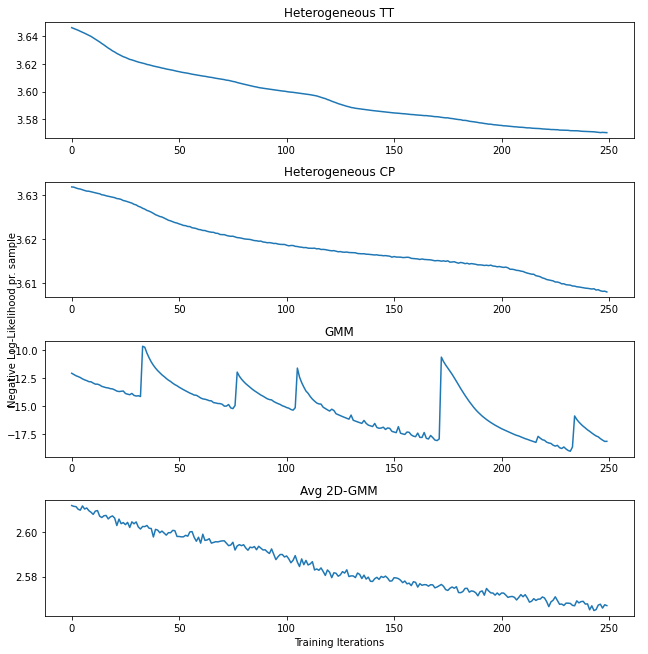

In [65]:
f, ax = plt.subplots(4, 1, figsize=(9, 9))
ax[0].plot(losses_TT)
ax[0].set_title("Heterogeneous TT")
ax[1].plot(losses_CP)
ax[1].set_title("Heterogeneous CP")
ax[2].plot(losses_GMM)
ax[2].set_title("GMM")
ax[3].plot((losses_GMM_1+losses_GMM_2+losses_GMM_3)/3)
ax[3].set_title("Avg 2D-GMM")
f.tight_layout()
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Training Iterations")
plt.ylabel("Negative Log-Likelihood pr. sample")
plt.show()

### Density Plots

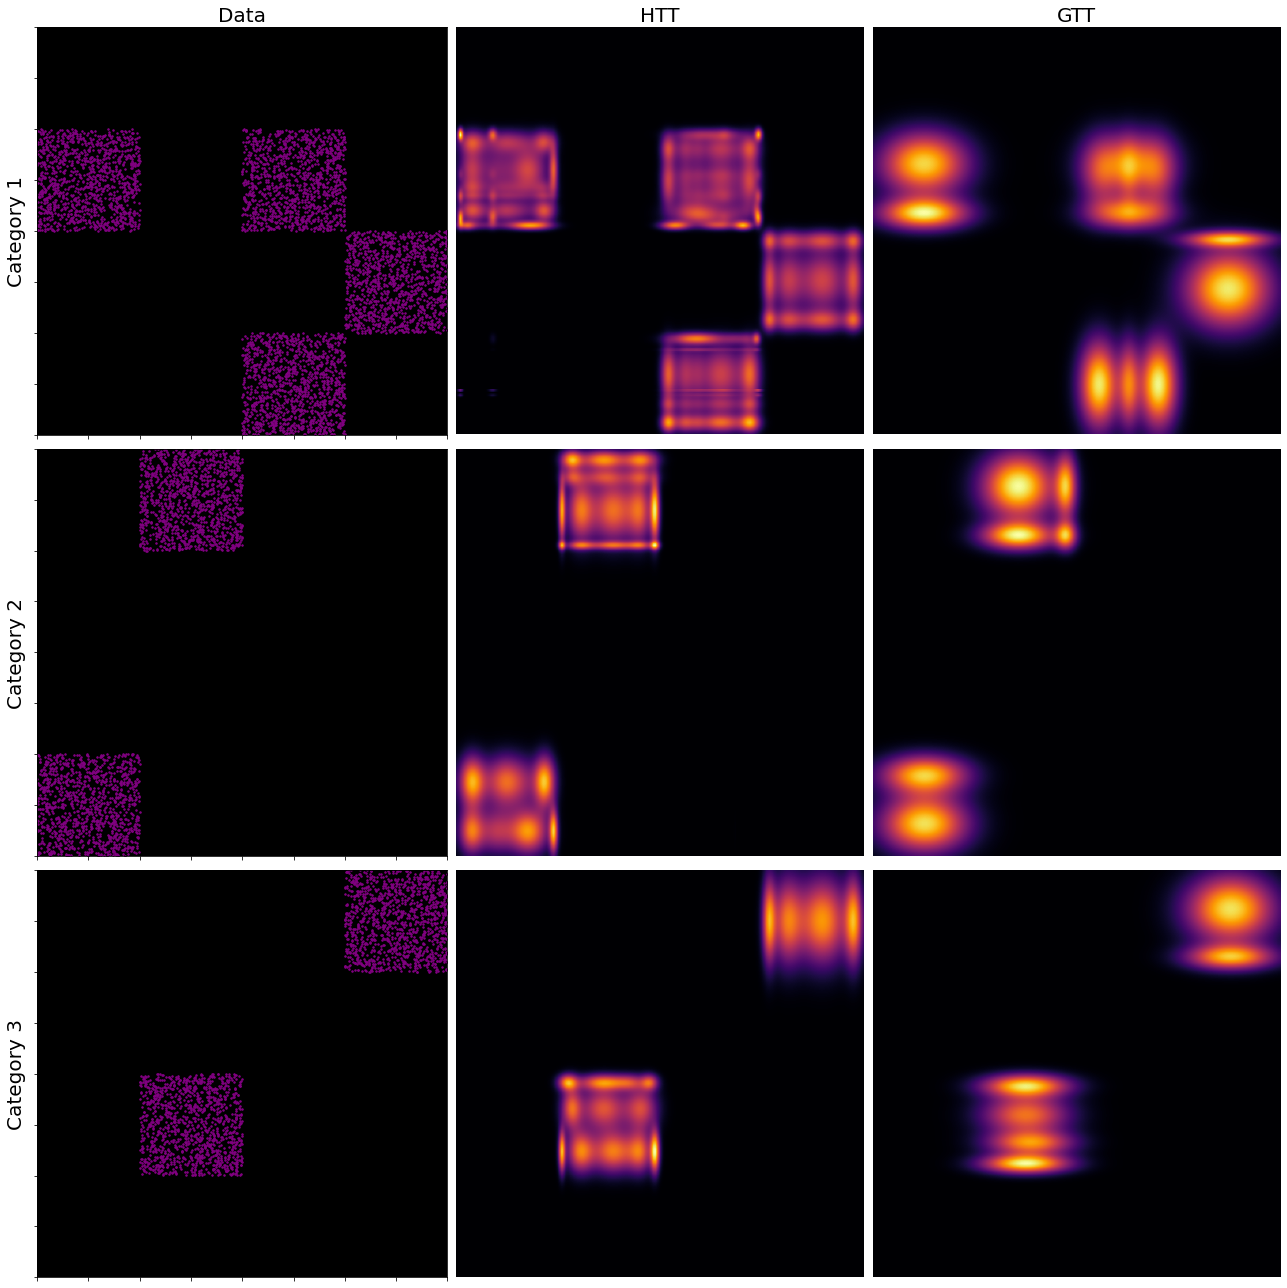

In [67]:
f, ax = plt.subplots(3, 3, figsize=(18, 18))

N_points = 1000

col = 'purple'
mark_size = 3
ax[0, 0].plot(points_1[:, 0], points_1[:, 1], '.', c=col, ms=mark_size)
ax[1, 0].plot(points_2[:, 0], points_2[:, 1], '.', c=col, ms=mark_size)
ax[2, 0].plot(points_3[:, 0], points_3[:, 1], '.', c=col, ms=mark_size)

for i in range(3):
    ax[i, 0].set_xlim((-4, 4))
    ax[i, 0].set_ylim((-4, 4))
    ax[i, 0].patch.set_facecolor('black')
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_xticklabels([])

utl.plot_density_3d_paper(
    TT, 
    ax[:, 1],
    cmap='inferno',
    n_points=N_points,
    limit=4
)
# utl.plot_density_3d_paper(
#     GMM, 
#     ax[:, 2],
#     cmap='inferno',
#     n_points=300,
#     limit=4
# )

utl.plot_density_2d_paper(
    GMM_1,
    ax[0, 2],
    cmap='inferno',
    n_points=N_points,
    limit=4
)
utl.plot_density_2d_paper(
    GMM_2,
    ax[1, 2],
    cmap='inferno',
    n_points=N_points,
    limit=4
)
utl.plot_density_2d_paper(
    GMM_3,
    ax[2, 2],
    cmap='inferno',
    n_points=N_points,
    limit=4
)

font_clr = "black"
ax[0, 0].set_title('Data', fontsize=20, color=font_clr)
ax[0, 1].set_title('HTT', fontsize=20, color=font_clr)
ax[0, 2].set_title('GTT', fontsize=20, color=font_clr)

ax[0, 0].set_ylabel('Category 1', fontsize=20, color=font_clr)
ax[1, 0].set_ylabel('Category 2', fontsize=20, color=font_clr)
ax[2, 0].set_ylabel('Category 3', fontsize=20, color=font_clr)

# f.patch.set_facecolor('black')
f.tight_layout()
plt.savefig('../figures/heterogenous_comparison_2.png')
plt.show()

### Sampling

In [ ]:
# sample from the models
N_samples = 1000
TT_samples = TT.sample(N_samples)
CP_samples = CP.sample(N_samples)
GMM_samples = GMM.sample(N_samples)

In [ ]:
# plot the samples
f, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(CP_samples[CP_samples[:, 2] == 0, 0], CP_samples[CP_samples[:, 2] == 0, 1], '.')
ax[0].plot(CP_samples[CP_samples[:, 2] == 1, 0], CP_samples[CP_samples[:, 2] == 1, 1], '.')
ax[0].plot(CP_samples[CP_samples[:, 2] == 2, 0], CP_samples[CP_samples[:, 2] == 2, 1], '.')
ax[0].set_title('Sampling from CP model')

ax[1].plot(TT_samples[TT_samples[:, 2] == 0, 0], TT_samples[TT_samples[:, 2] == 0, 1], '.')
ax[1].plot(TT_samples[TT_samples[:, 2] == 1, 0], TT_samples[TT_samples[:, 2] == 1, 1], '.')
ax[1].plot(TT_samples[TT_samples[:, 2] == 2, 0], TT_samples[TT_samples[:, 2] == 2, 1], '.')
ax[1].set_title('Sampling from TT model')

ax[2].plot(GMM_samples[np.round(GMM_samples[:, 2]) == 0, 0], GMM_samples[np.round(GMM_samples[:, 2]) == 0, 1], '.')
ax[2].plot(GMM_samples[np.round(GMM_samples[:, 2]) == 1, 0], GMM_samples[np.round(GMM_samples[:, 2]) == 1, 1], '.')
ax[2].plot(GMM_samples[np.round(GMM_samples[:, 2]) == 2, 0], GMM_samples[np.round(GMM_samples[:, 2]) == 2, 1], '.')
ax[2].set_title('Sampling from GMM model')

plt.show()